## Review
아래 코드와 유사한 방식으로 본인의 코드가 작동하는지 확인해보세요.
- `.py` script에 dataset을 잘 넣어서 불러올 수 있는지
- DataLoader에 씌우고 배치를 뽑아볼 수 있는지
- 그림 그려볼 수 있는지

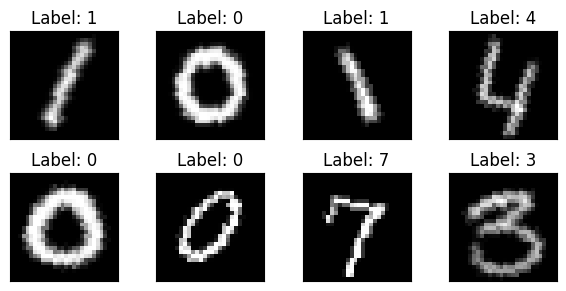

In [1]:
from torch.utils.data import DataLoader

from digitrec.plot_utils import plot_tensors
from digitrec.dataloader import DigitDataset

dataset = DigitDataset(data_dir="./data", file_name="train.csv")
dataloader = DataLoader(dataset, batch_size=16)

X, y = next(iter(dataloader))
plot_tensors(X=X.squeeze(), y=y)

## import `timm`

In [2]:
import timm

model = timm.create_model("resnet10t", num_classes=10, in_chans=1)

### Apply changes

In [3]:
model(X).shape

torch.Size([16, 10])

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

4927186

### Train a model

Single Batch Operation

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Use available device
# I have no GPU = "cpu"
# I'm working with gpus = "gpu" or "cuda"
# I'm working with Mac M1 series = "mps" << requires torch version >= 1.13
device = torch.device("mps")

In [7]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# Fetch a batch
img, y_true = next(iter(dataloader))
img, y_true = img.to(device), y_true.to(device)

# Forward image
y_pred = model(img)

# Calculate Loss
loss = loss_fn(y_pred, y_true)

# Backpropagate Loss
optimizer.zero_grad()
loss.backward()
optimizer.step()

Iterate through whole dataloader

In [9]:
for img, y_true in dataloader:

    img, y_true = img.to(device), y_true.to(device)
    y_pred = model(img)

    loss = loss_fn(y_pred, y_true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Go through multiple epochs!

In [10]:
for epoch in range(5):
    for img, y_true in dataloader:
        img, y_true = img.to(device), y_true.to(device)
        y_pred = model(img)

        # Calculate Loss
        loss = loss_fn(y_pred, y_true)

        # Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Check with validation data

In [11]:
valid_dataset = DigitDataset(data_dir="./data", file_name="train.csv", mode="valid", use_augmentation=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=16)

img, y_true = next(iter(valid_dataloader))

In [12]:
y_pred = model(img.to(device))

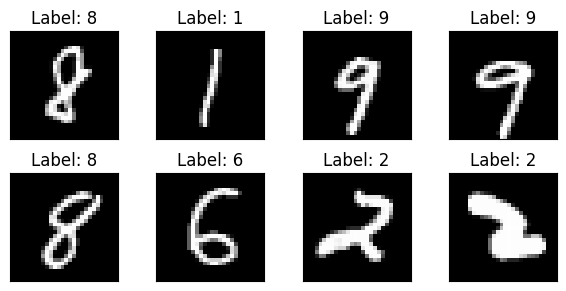

In [13]:
# 생각보다 잘 나옴
plot_tensors(img.squeeze(), y_pred.argmax(dim=1).cpu())

### Functionize

In [15]:
device = torch.device("mps")
model = timm.create_model("resnet10t", num_classes=10, in_chans=1).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
batch_size = 64

train_dataset = DigitDataset(data_dir="./data", file_name="train.csv", mode="train")
valid_dataset = DigitDataset(data_dir="./data", file_name="train.csv", mode="valid", use_augmentation=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)


def _epoch(dataloader: DataLoader, update_params: bool = True):
    for img, y_true in dataloader:
        img, y_true = img.to(device), y_true.to(device)
        y_pred = model(img)

        loss = loss_fn(y_pred, y_true)

        if update_params:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model


def train(model: nn.Module, epochs=10):
    for e in range(epochs):
        model = _epoch(dataloader=train_dataloader, update_params=True)
        model = _epoch(dataloader=valid_dataloader, update_params=False)
    return model

In [16]:
model = train(model, epochs=5)

### `Class`

전역변수가 너무 많습니다. 일일히 설정하는 것은 관리가 힘들어요. 이를 Class에 넣어서 attribute으로 넣어두면 사용하긱 ㅏ편합니다.

In [4]:
class Trainer:
    def __init__(self,
                 model: nn.Module,
                 optimizer: str,
                 device: str = "mps",
                 data_dir: str = "./data",
                 file_name: str = "train.csv",
                 batch_size: int = 64):
        self.model = model.to(device)
        self.device = device
        self.configure_optimizer(optimizer=optimizer, model=self.model)
        self.loss_fn = nn.CrossEntropyLoss()

        train_dataset = DigitDataset(data_dir=data_dir, file_name=file_name, mode="train")
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
        valid_dataset = DigitDataset(data_dir=data_dir, file_name=file_name, mode="valid", use_augmentation=False)
        self.valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

    def configure_optimizer(self, optimizer: str, model: nn.Module):
        self.optimizer = {
            "adam": optim.Adam,
            "adamw": optim.AdamW
        }[optimizer.lower()](model.parameters())

    def _epoch(self, dataloader: DataLoader, update_params: bool = True):
        for img, y_true in dataloader:
            img, y_true = img.to(self.device), y_true.to(self.device)
            y_pred = self.model(img)

            loss = self.loss_fn(y_pred, y_true)

            if update_params:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def fit(self, epochs=20):
        for e in range(epochs):
            self._epoch(dataloader=self.train_dataloader, update_params=True)
            self._epoch(dataloader=self.valid_dataloader, update_params=False)

In [5]:
model = timm.create_model("resnet10t", num_classes=10, in_chans=1)
trainer = Trainer(model=model, optimizer="adam")

trainer.fit(epochs=10)

Validate on test data

In [6]:
test_dataset = DigitDataset(data_dir="./data", file_name="test.csv", mode=None, use_augmentation=False)
test_dataloader = DataLoader(test_dataset, batch_size=8)

img = next(iter(test_dataloader))
y_pred = trainer.model(img.to(trainer.device))

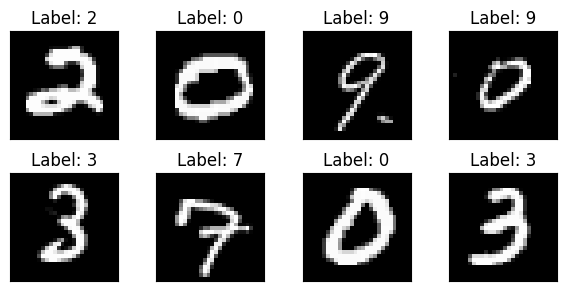

In [7]:
plot_tensors(img.squeeze(), y_pred.argmax(dim=1))